In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
% env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
import sys; sys.path += ['..', '../src']

In [4]:
import os
from itertools import islice

from src.vocab import Vocab

DATA_PATH = '../data/generated'

# We set rather large min_len, because our BPEs are very short
min_len = 50
max_len = 150

classics_path = os.path.join(DATA_PATH, 'classics.tok.bpe')
news_path = os.path.join(DATA_PATH, 'news.ru.tok.bpe')

classics = open(classics_path, 'r', encoding='utf-8').read().splitlines()
news = open(news_path, 'r', encoding='utf-8').read().splitlines()
# TODO: replace with full file when dev is done
# with open(classics_path, encoding='utf-8') as classics_file, open(news_path, encoding='utf-8') as news_file:
#     classics = list(islice(classics_file, 10**4))
#     news = list(islice(news_file, 10**4))

classics = [s for s in classics if min_len < len(s.split()) < (max_len - 2)]
news = [s for s in news if min_len < len(s.split()) < (max_len - 2)]

# There are sentences which do not contain a single normal
# (i.e. fully alphabetic) word. Let's remove them.
classics = [s for s in classics if any([w.isalpha() for w in s.replace('@@ ', '').split()])]
news = [s for s in news if any([w.isalpha() for w in s.replace('@@ ', '').split()])]

vocab = Vocab.from_sequences(classics + news)
vocab.token2id['__DROP__'] = len(vocab)
vocab.tokens.append('__DROP__')

In [5]:
import random
import numpy as np

np.random.seed(42)

np.random.shuffle(classics)
np.random.shuffle(news)

In [6]:
classics, classics_val = classics[:-1000], classics[-1000:]
news, news_val = news[:-1000], news[-1000:]

In [7]:
%matplotlib inline

import os
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam

from src.models import Transformer
from src.dataloaders import WordRecoveryDataloader, OneSidedDataloader
from src.vocab import constants
from src.trainers import WordRecoveryTrainer

log_file_path = '../logs/word_recovery.log'

# Let's clean log file
if os.path.exists(log_file_path): os.remove(log_file_path)

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

transformer = Transformer(len(vocab), len(vocab), max_len)
transformer.load_state_dict(torch.load('../trained_models/word_recovery.pth'))

optimizer = Adam(transformer.get_trainable_parameters(), lr=1e-5)
criterion = reconstruction_criterion(len(vocab))

config = {
    'max_num_epochs': 5,
    'plot_every': 50,
    'validate_every': 200,
    'mixing_scheme': (0.5, 0.1, 100000),
    'log_file': log_file_path,
    'max_len': 20
}

trainer = WordRecoveryTrainer(transformer, optimizer, criterion, vocab, config)
training_data = WordRecoveryDataloader(classics, news, vocab, trainer.mixing_coef, batch_size=32, shuffle=True)
val_data = WordRecoveryDataloader(classics_val[:512], news_val[:512], vocab, batch_size=512)

# Making validation data deterministic
val_data = np.array(next(val_data)).transpose().tolist()
val_data = OneSidedDataloader(val_data, batch_size=32, unpack=True, pad=False)

In [ ]:
trainer.max_num_epochs = 10

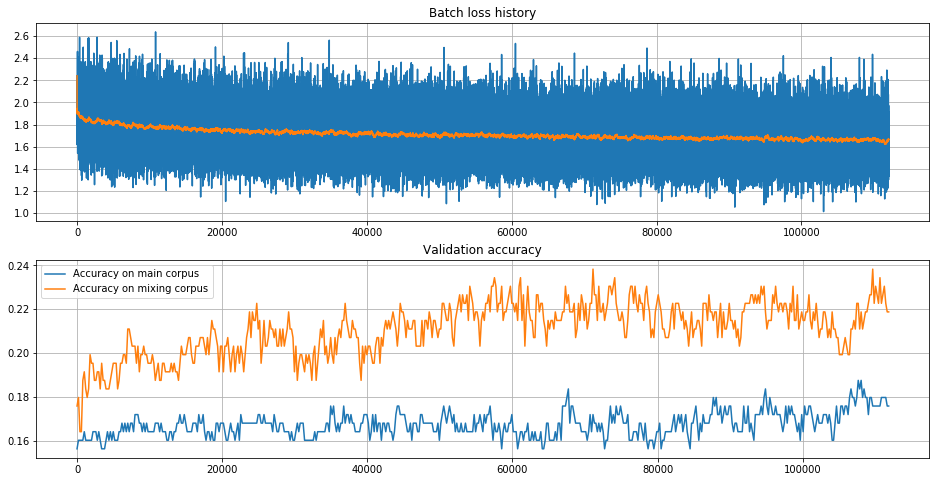

In [8]:
trainer.run_training(training_data, val_data)

In [9]:
torch.save(transformer.state_dict(), '../trained_models/word_recovery.pth')

Ok, let's now try to translate some news.
For this we should generate from a sentence (of $n$ words) $n$ sentences with `__DROP__` word in place of each word.
Named entities, I suppose, should be transferred as is. But this will be the next iteration.

In [24]:
from tqdm import tqdm

from src.dataloaders.word_recovery_dataloader import drop_each_word, group_bpes_into_words
from src.utils.data_utils import token_ids_to_sents, pad_to_longest
from src.vocab import constants

news_test = news_val[5:10]
news_test = [s for s in news_test if len(s.split()) < max_len]
results = []

transformer.eval()

for sentence in tqdm(news_test):
    seqs, _, words_idx = drop_each_word(sentence)
    seqs_idx = [[vocab.token2id[t] for t in s.split()] for s in seqs]
    seqs_idx = [[constants.BOS] + s + [constants.EOS] for s in seqs_idx]
    seqs_idx = pad_to_longest(seqs_idx, volatile=True)
    predictions = transformer.translate_batch(seqs_idx, beam_size=6, max_len=20)
    predictions = token_ids_to_sents(predictions, vocab)
    
    # Now we should construct initial sentence with some care,
    # because not each word was dropped, but only normal ones (fully alphabetical)
    words = group_bpes_into_words(sentence)
    for i, w in enumerate(predictions): words[words_idx[i]] = w
    sentence = ' '.join(words)

    results.append(sentence)

for i in range(len(news_test)):
    print('Source: ', news_test[i].replace('@@ ', ''))
    print('Result: ', results[i].replace('@@ ', ''))
    print()

100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

Source:  Если пассажир отказывается выполнять любые требования по обеспечению безопасности полетов и авиационной безопасности воздушного судна , его ждет заключение сроком до трех месяцев или административный штраф до € 206 ( ст. 1095 Воздушного кодекса Италии ) .
Result:  Если он может на свои уки по вопросам уки экономической и для части для уровня , то принимают с довести до двух пор в за срок с € 206 ( ст. 1095 Уголовного комитета РФ ) .

Source:  По мнению следствия , если Евгений Урлашов &quot; имел возможность давать распоряжения , то он также может оказывать давление на свидетелей и просить своих посредников скрыть улики или документы , подтверждающие его вину &quot; .
Result:  По версии СМИ , если Дмитрий Кн &quot; имеет право разить наки , то он не решил принять надежду для Украине и заставляет своих и на уки и проки , выить к уки &quot; .

Source:  Ситуация с приезжими в Германии обострилась после событий на Новый год в Кельне , когда тысяча мигрантов , разделившись на групп